In [1]:
from larcv import larcv
larcv.load_pyutil
larcv.load_cvutil

import cv2
import ROOT
from ROOT import fcllite
from ROOT import geo2d
from ROOT import larocv

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

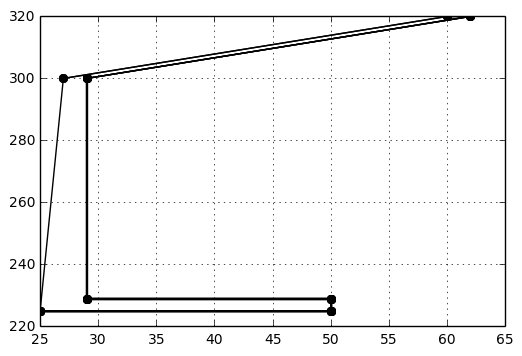

In [2]:
# make a fake image...
a=np.zeros((485,485))

ctor = ROOT.std.vector(ROOT.cv.Point_('int'))()

ctor.clear()
    
pt_x=[]
pt_y=[]

ctor.push_back(ROOT.cv.Point_("int")(25,225))
ctor.push_back(ROOT.cv.Point_("int")(50,225))
ctor.push_back(ROOT.cv.Point_("int")(50,229))
ctor.push_back(ROOT.cv.Point_("int")(29,229))
ctor.push_back(ROOT.cv.Point_("int")(29,300))
ctor.push_back(ROOT.cv.Point_("int")(62,320))
ctor.push_back(ROOT.cv.Point_("int")(60,320))
ctor.push_back(ROOT.cv.Point_("int")(27,300))

ctor.push_back(ctor[0])
for pt in ctor:
    pt_x.append(pt.x)
    pt_y.append(pt.y)
    plt.plot(pt_x,pt_y,'o-',color='black',lw=1)

ax=plt.gca()
#ax.set_xlim(0,450)
#ax.set_ylim(0,450)
plt.grid()
plt.show()

# make a path representing this contour
path_list1 = []
for pt in ctor:
    path_list1.append((pt.x,pt.y)) 


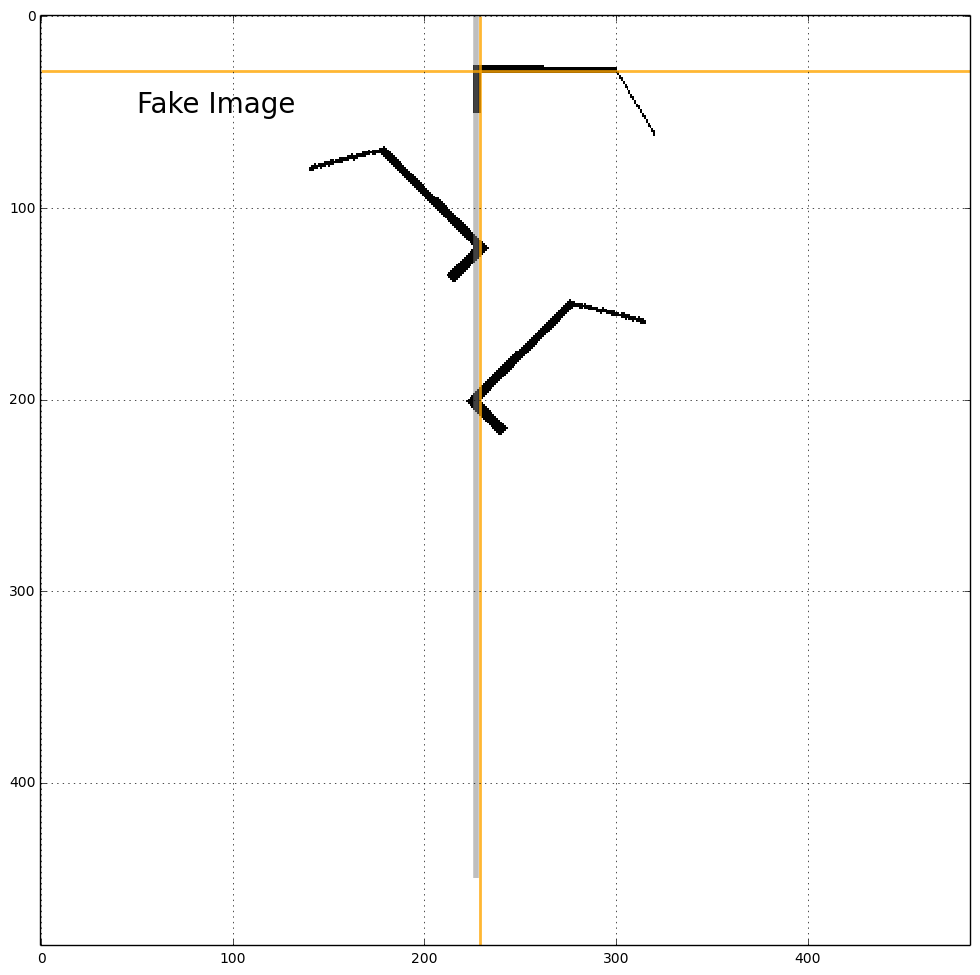

In [3]:
path1 = matplotlib.path.Path(path_list1)

img1 = path1.contains_points(np.row_stack(np.where(a==0)).T).reshape(485,485).astype(np.uint8)

img1=np.where(img1>0,img1+80,0)
img2 = img1.copy()
img3 = img1.copy()
M = cv2.getRotationMatrix2D((485/2,485/2),45,1)

#rotate 2
img2 = cv2.warpAffine(img2,M,(485,485))

#flip 2
img2 = img2[:,::-1]

#get nonzero for 2, and move it...
nzero=np.row_stack(np.where(img2>0)).T
img2[nzero[:,0],nzero[:,1]]=0
img2[nzero[:,0]+20,nzero[:,1]-174]=80

#rotate 3
M = cv2.getRotationMatrix2D((485/2,485/2),45,1)
img3 = cv2.warpAffine(img3,M,(485,485))

#get nonzero for 3, and move it...
nzero=np.row_stack(np.where(img3>0)).T
img3[nzero[:,0],nzero[:,1]]=0
img3[nzero[:,0]+100,nzero[:,1]+145]=80

#add them...
img = img1+img2+img3

plt.imshow(img,cmap='Greys',interpolation='none')
ax=plt.gca()
ax.vlines(227,0,450,color='grey',lw=4,alpha=0.5)
ax.hlines(28.4845,0,485,color='orange',alpha=0.8,lw=2)
ax.vlines(485-256,0,485,color='orange',alpha=0.8,lw=2)
ax.text(50,50,"Fake Image",fontsize=20)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.grid()
plt.show()

In [4]:
iom = larcv.IOManager(larcv.IOManager.kWRITE)
iom.set_verbosity(0)
iom.set_out_file("/tmp/aho.root")
iom.initialize()
fake_evimg=iom.get_data(larcv.kProductImage2D,"test")

img2d1 = larcv.as_image2d(img1)
img2d2 = larcv.as_image2d(img2)
img2d3 = larcv.as_image2d(img3)

imeta1 = larcv.ImageMeta(485,2910.0,
                   485,485,
                   166.0,5424.0,
                   0)

imeta2 = larcv.ImageMeta(485,2910.0,
                   485,485,
                   621.0,5424.0,
                   1)

imeta3 = larcv.ImageMeta(485,2910.0,
                   485,485,
                   343.,5424.0,
                   2)

img2d1 = larcv.Image2D(imeta1,img2d1.as_vector())
img2d2 = larcv.Image2D(imeta2,img2d2.as_vector())
img2d3 = larcv.Image2D(imeta3,img2d3.as_vector())


fake_evimg.Append(img2d1)
fake_evimg.Append(img2d2)
fake_evimg.Append(img2d3)

iom.set_id(0,0,1)
iom.save_entry()
iom.finalize()

In [5]:
proc = larcv.ProcessDriver("ProcessDriver")
proc.configure("track_particle_cluster.cfg")
f=ROOT.std.string("/tmp/aho.root")
flist=ROOT.std.vector('string')()
flist.push_back(f)
proc.override_input_file(flist)
proc.initialize()
larbysimg = proc.process_ptr(0)

In [6]:
proc.batch_process(0,1)

In [7]:
mgr=larbysimg.Manager()
img_v = []
pygeo = geo2d.PyDraw()

In [8]:
for mat in mgr.InputImages():
    img_v.append(pygeo.image(mat))

See  9  vtxID
See  9  vtxID
See  9  vtxID


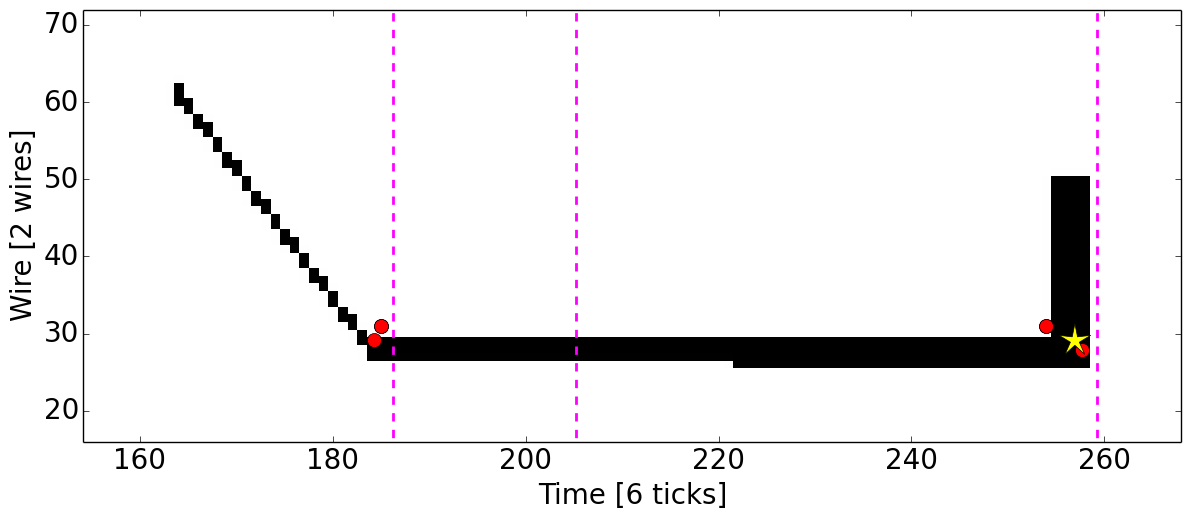

See  9  vtxID
See  9  vtxID
See  9  vtxID


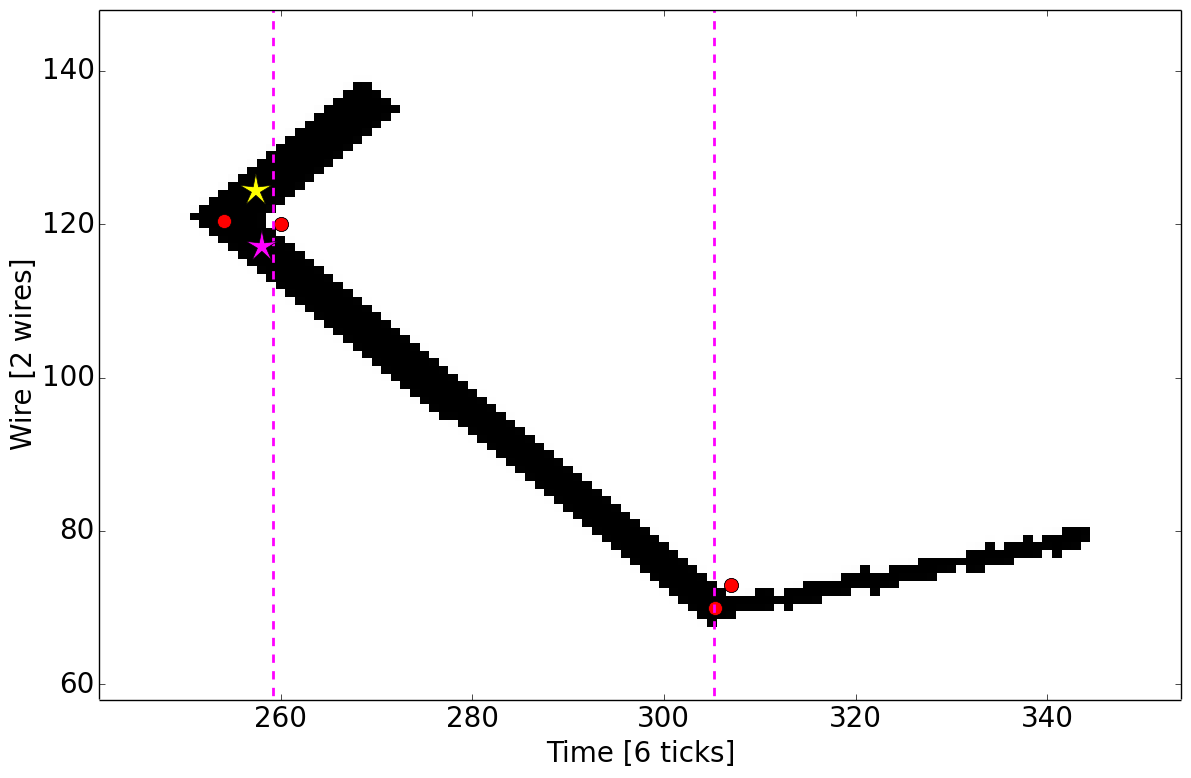

See  9  vtxID
See  9  vtxID
See  9  vtxID


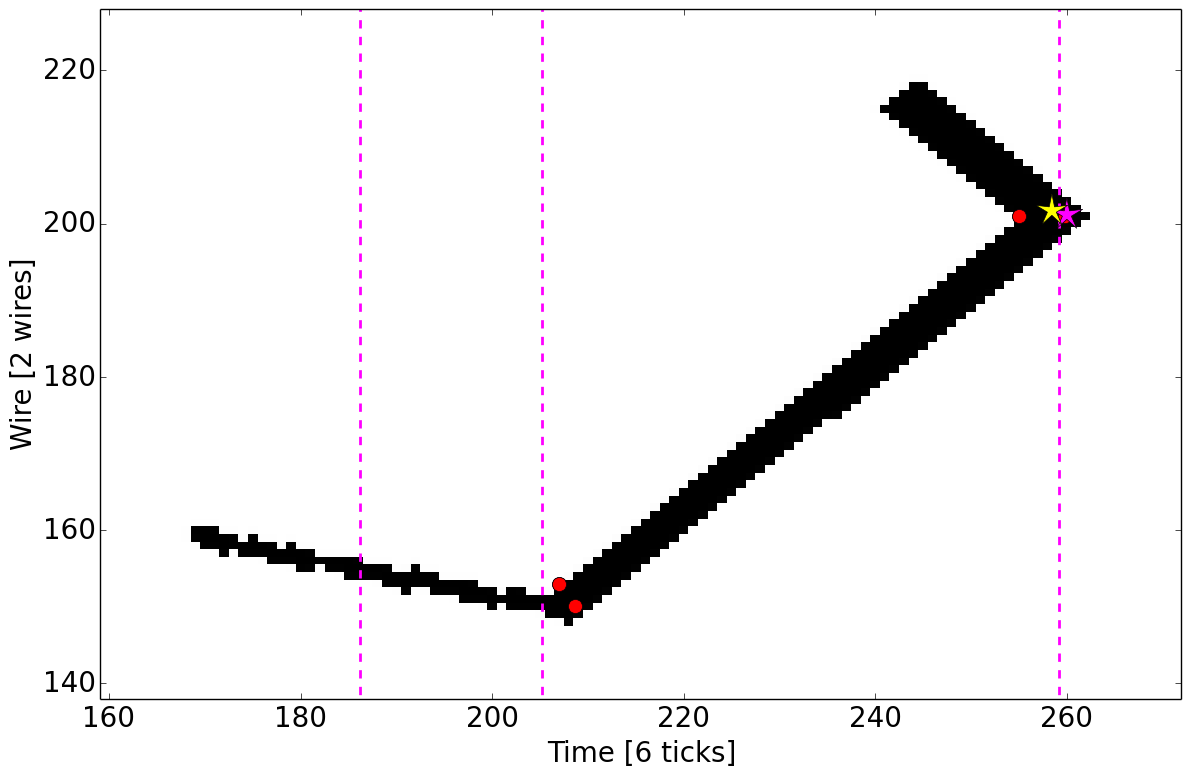

In [9]:
import matplotlib.patches as patches

for plane in xrange(3):
    fig,ax=plt.subplots(figsize=(12,12),facecolor='w')
    shape_img=np.where(img_v[plane]>10.0,1.0,0.0).astype(np.uint8)
    plt.imshow(shape_img,cmap='Greys',interpolation='none')
    nz_pixels=np.where(shape_img>0.0)

    alg = mgr.GetClusterAlg(2).Algo()
    
    cv=larbysimg.Manager().GetClusterAlg(1)
    mgr=larbysimg.Manager()
    dm=mgr.DataManager()
    
    #Getting seeds
    seeds_data0=dm.Data(1,plane)
    seeds_data1=dm.Data(1,plane+3)
    for compound in seeds_data1.as_vector():
        for defect in compound.get_defects():
            pt = defect._pt_defect
            plt.plot([pt.x],[pt.y],marker='o',color='blue',markersize=10)
    for pt in seeds_data0.as_vector():
        plt.plot([pt.x],[pt.y],marker='o',color='red',markersize=10)
            
    ref_data   = dm.Data(2,0).as_vector()
    plane_scan = alg.PlaneInfo(plane)

    for circle in plane_scan._circle_scan_v:
        c=patches.Circle((circle.center.x,circle.center.y),circle.radius,ec='cyan',alpha=0.05,fc='none',lw=10)
        ax.add_patch(c)

    minimum_v = alg.TimeBinnedScoreMinIndex()
    for idx in xrange(minimum_v.size()):
        xval = minimum_v[idx] + alg.TimeBinMin()
        plt.plot([xval,xval],[0,2000],marker='',linestyle='--',color='magenta',linewidth=2)

    for vtx3d in ref_data:
        print "See ",vtx3d.ID()," vtxID"
        vtx = vtx3d.cvtx2d_v[plane]
        color='magenta'
        if vtx3d.type == 1:
            color='yellow'
        plt.plot([vtx.center.x],[vtx.center.y],marker='$\star$',color=color,markersize=24)

    ymin,ymax = (np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
    xmin,xmax = (np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)

    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    plt.xlabel('Time [6 ticks]',fontsize=20)
    plt.ylabel('Wire [2 wires]',fontsize=20)
    plt.tick_params(labelsize=20)
    ax.set_aspect(0.8)
    plt.tight_layout()
    ax=plt.gca()
    plt.show()
    


In [10]:
assman=dm.AssManager()

There are  3 vertex found in this event. Note that this is vertex-wise



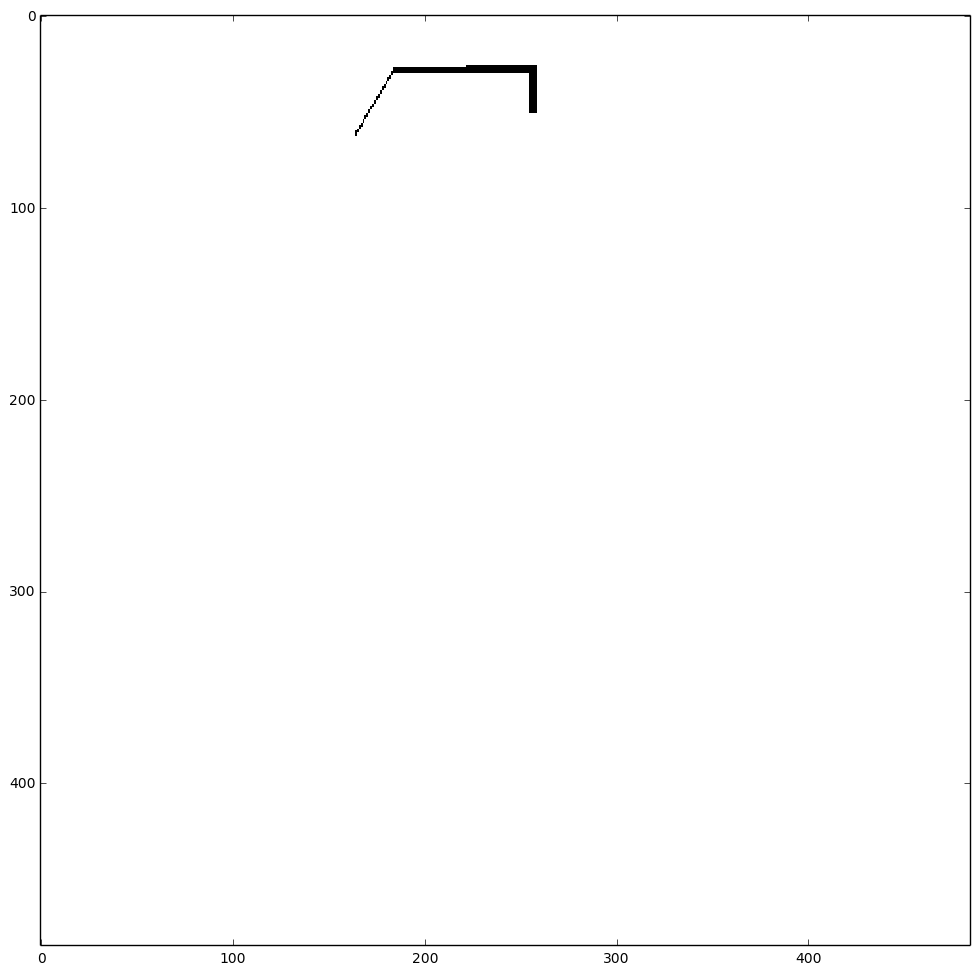

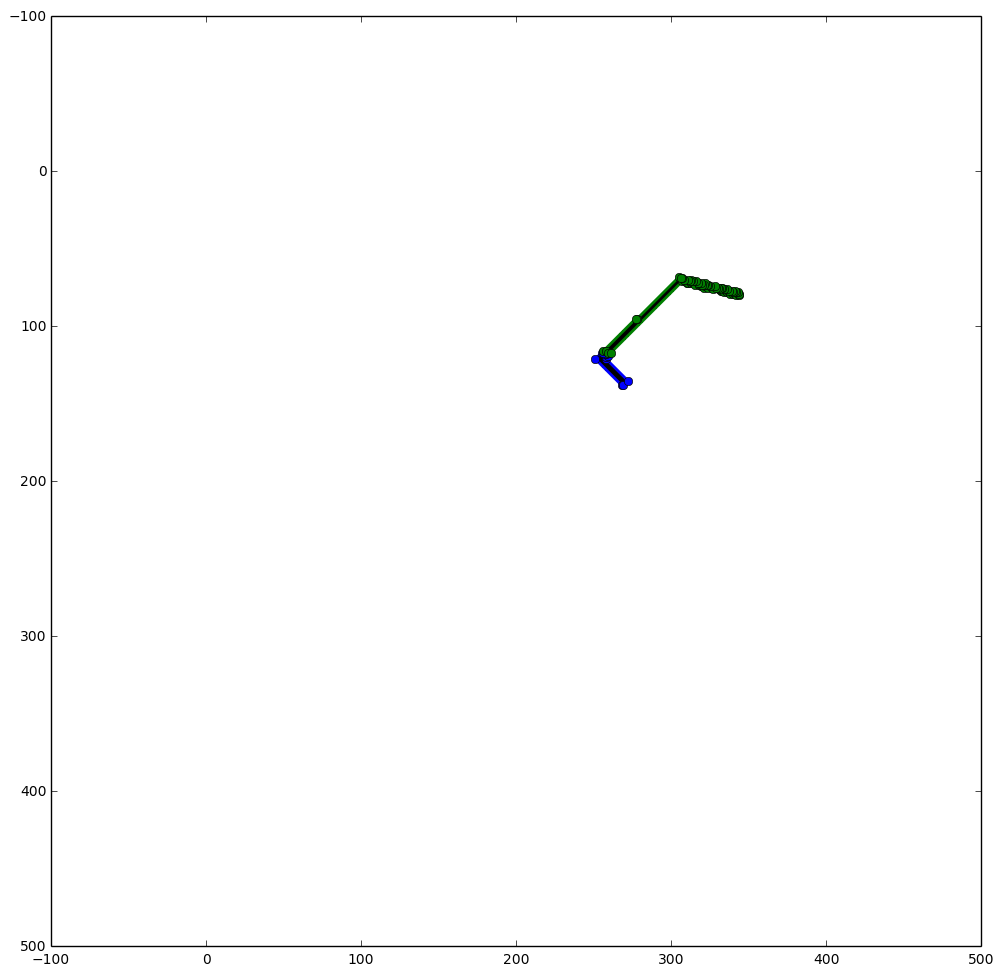

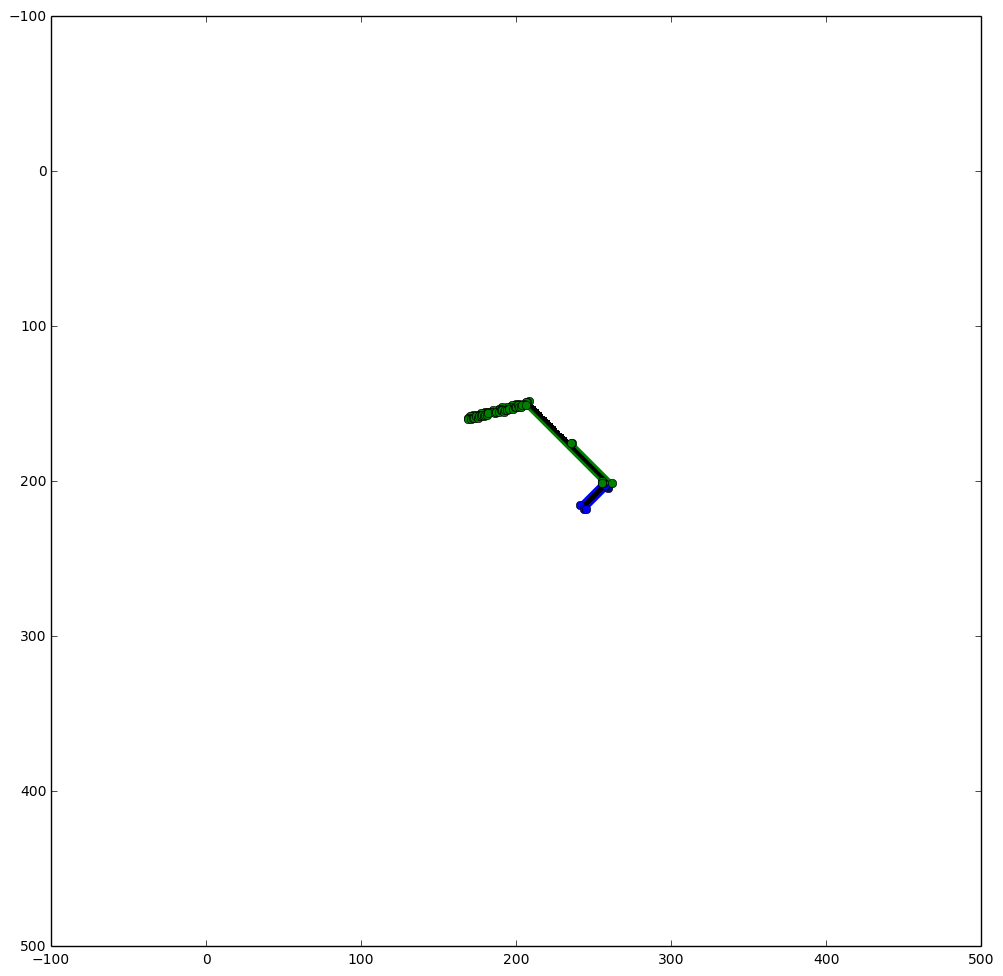

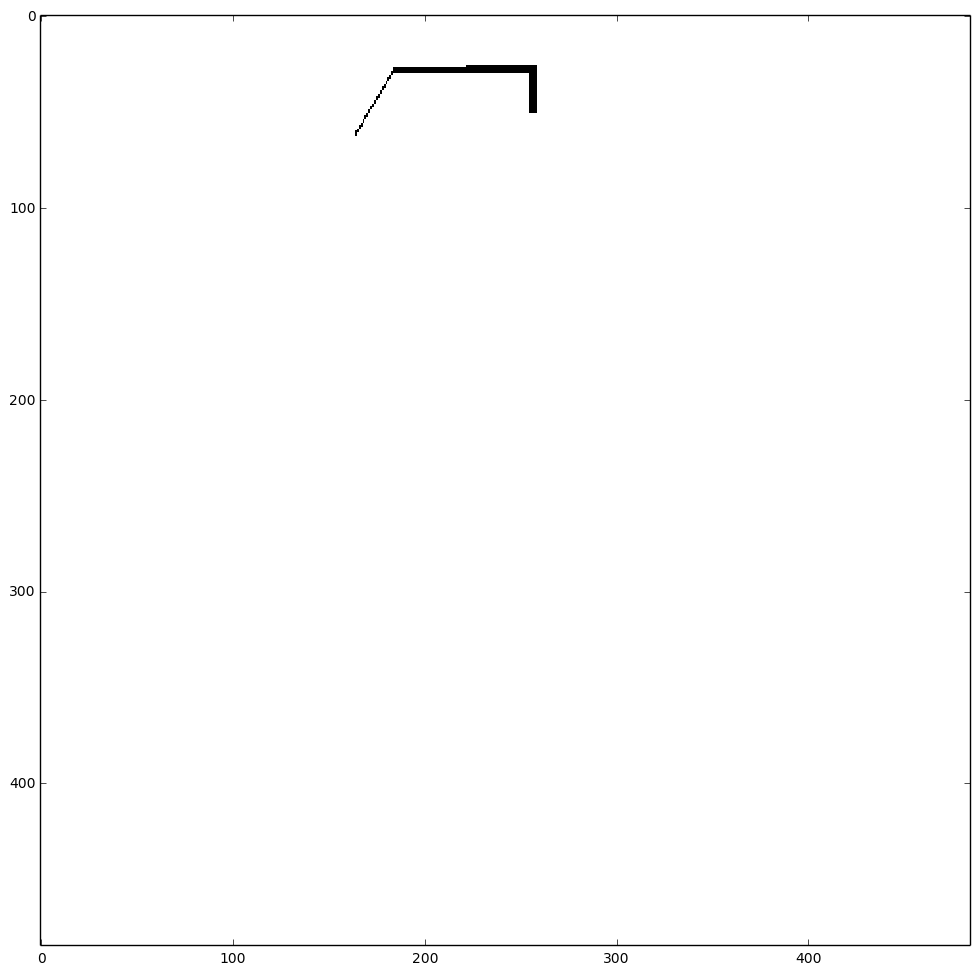

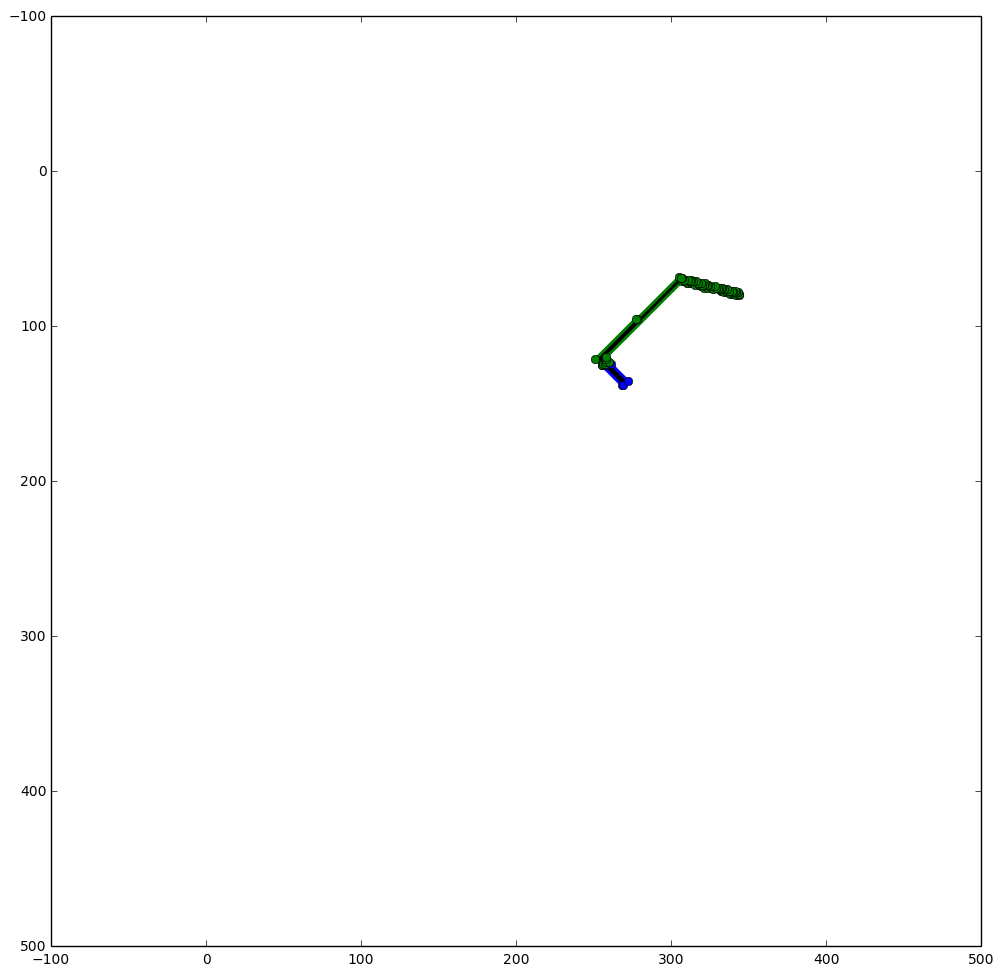

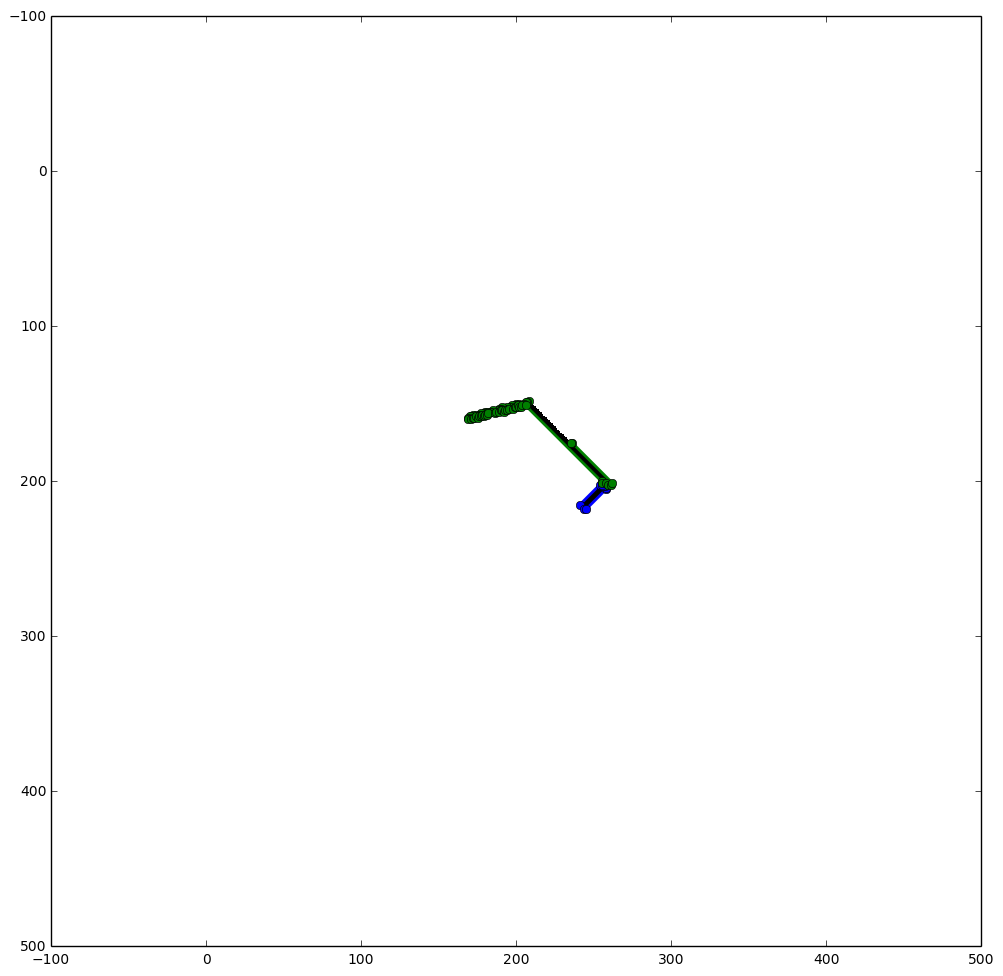

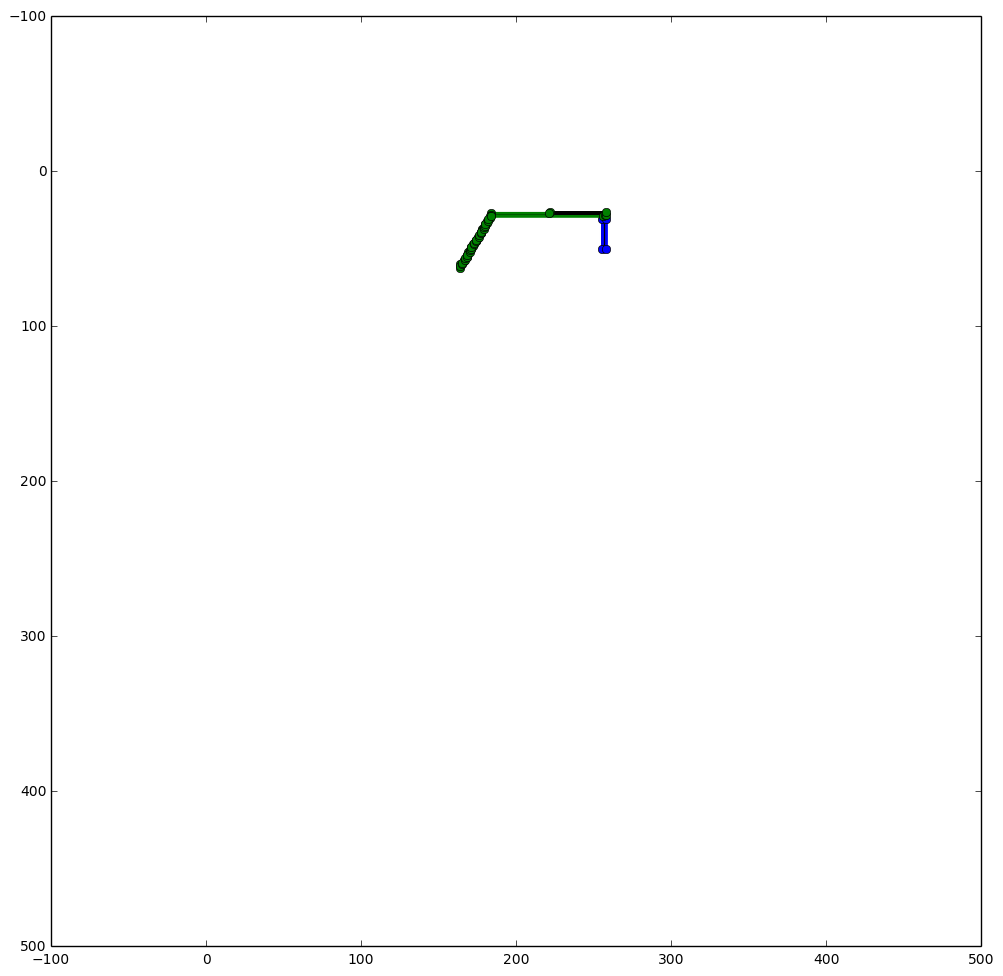

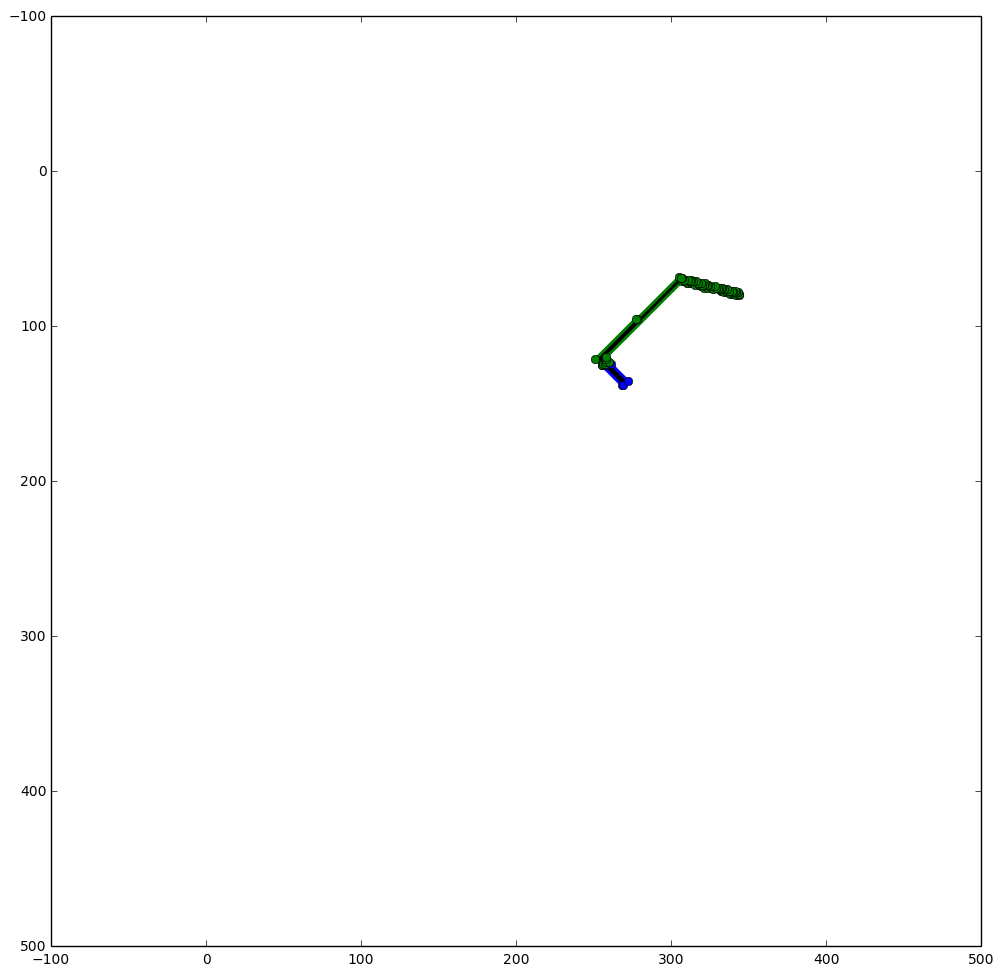

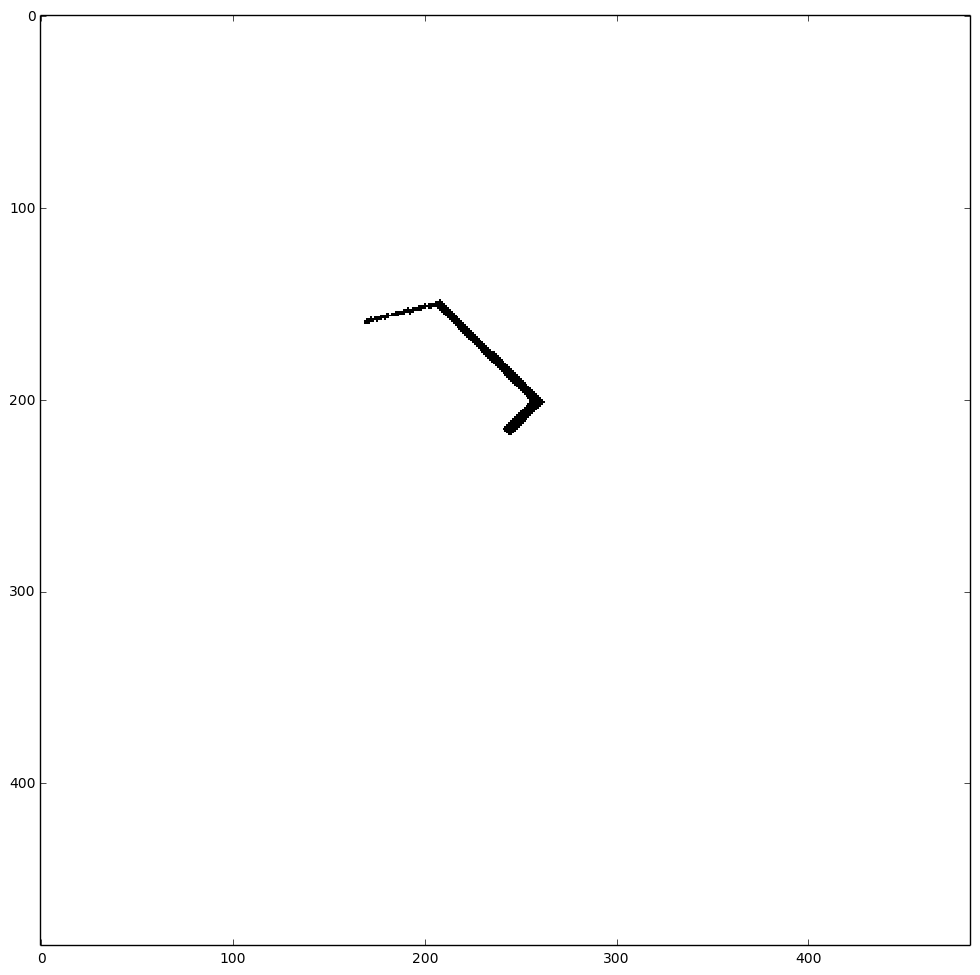

In [11]:
assman=dm.AssManager()
#New VertexCluster
vtx_data=dm.Data(2,0).as_vector()
dm
#Simply a list of VertexCluster (i.e. vertex-wise list of clusters)
print "There are ",vtx_data.size(),"vertex found in this event. Note that this is vertex-wise"
print

for vtx in vtx_data:
    for plane in xrange(3):
        fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
        shape_img = img_v[plane]
        shape_img=np.where(img_v[plane]>10.0,1.0,0.0).astype(np.uint8)
        plt.imshow(shape_img,cmap='Greys',interpolation='none')
        nz_pixels=np.where(shape_img>0.0)
        
        par_data=dm.Data(3,plane)
        
        ass_t = np.array(assman.GetManyAss(vtx,par_data.ID()))
        if ass_t.size==0:continue
            
        par_data_v=par_data.as_vector()
        for id_ in ass_t:
            ctor=np.array([[pt.x,pt.y] for pt in par_data_v[id_]._ctor])
            plt.plot(ctor[:,0],ctor[:,1],'-o',lw=2)
        

        
        plt.show()


There are  3 vertex found in this event. Note that this is vertex-wise

<ROOT.larocv::data::AtomicContour object at 0x7fe32204f7d0> 4
<ROOT.larocv::data::AtomicContour object at 0x7fe322512d50> 53
<ROOT.larocv::data::AtomicContour object at 0x7fe322512dd8> 10


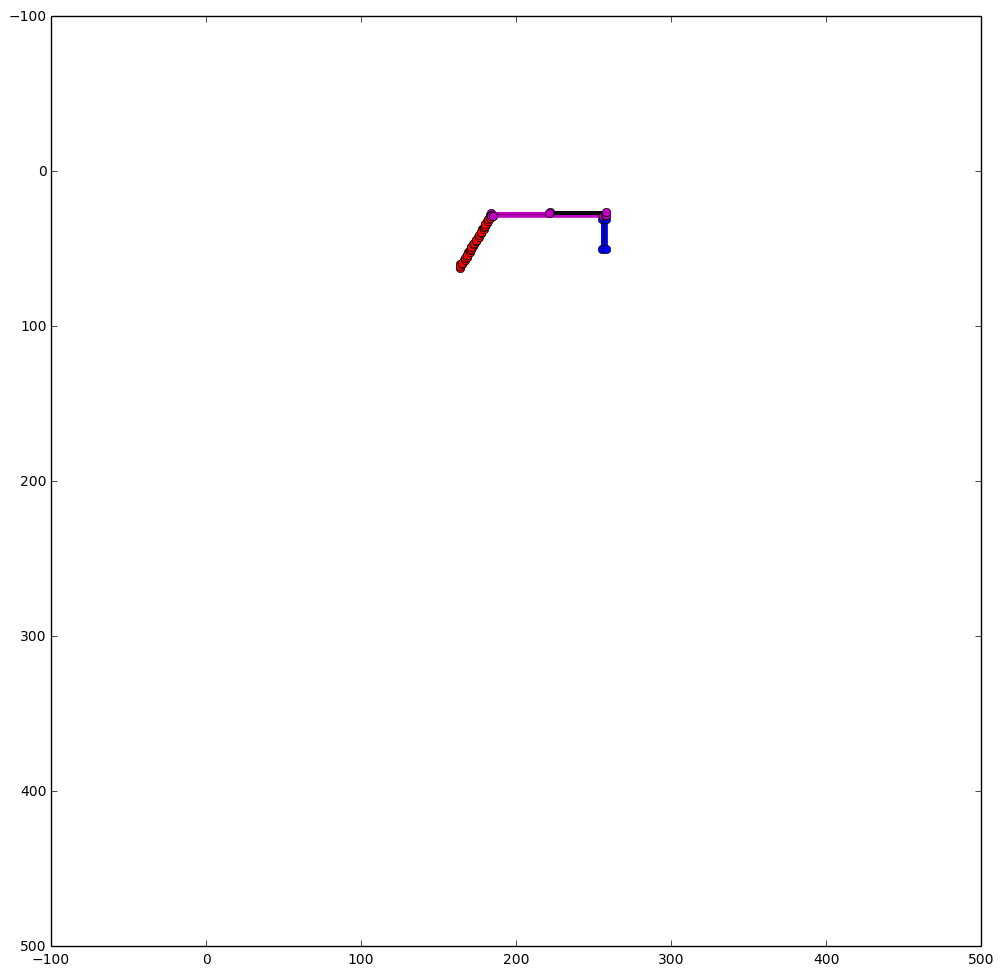

<ROOT.larocv::data::AtomicContour object at 0x7fe32204fec0> 11
<ROOT.larocv::data::AtomicContour object at 0x7fe322054370> 9
<ROOT.larocv::data::AtomicContour object at 0x7fe3220543f8> 61


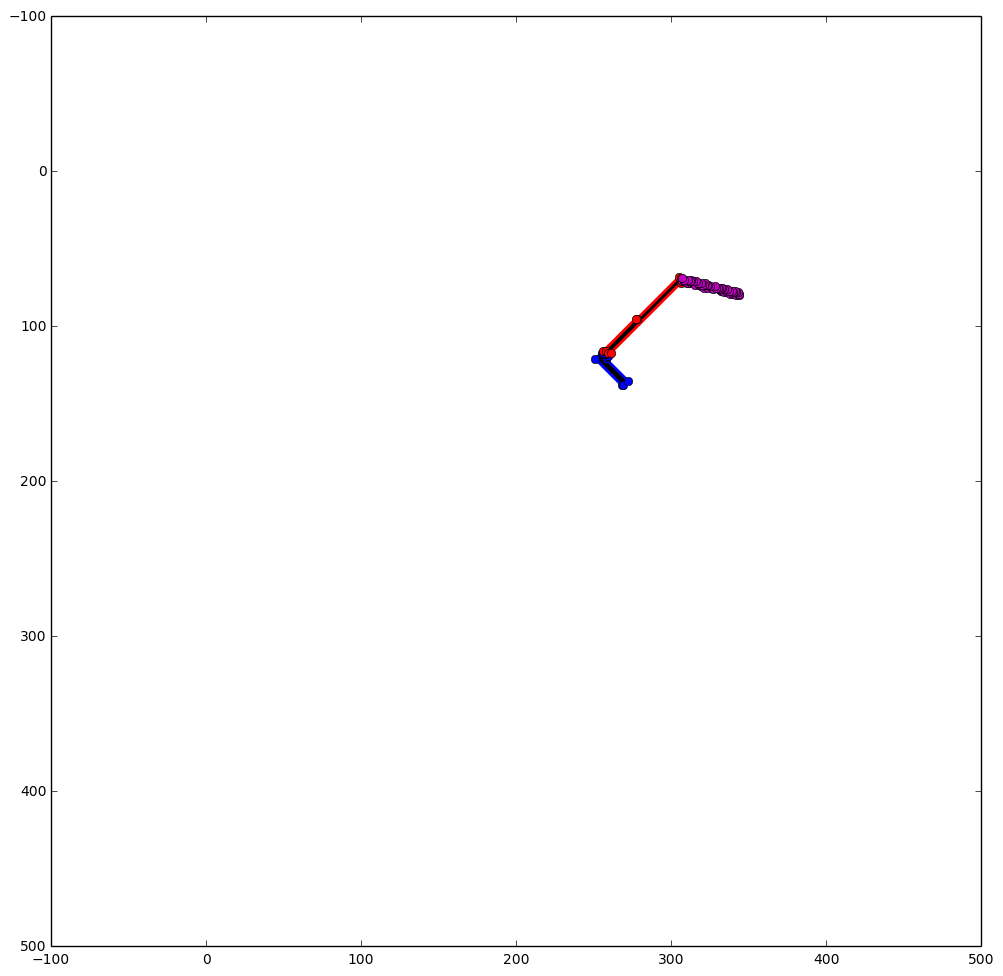

<ROOT.larocv::data::AtomicContour object at 0x7fe322056060> 9
<ROOT.larocv::data::AtomicContour object at 0x7fe322057870> 7
<ROOT.larocv::data::AtomicContour object at 0x7fe3220578f8> 63


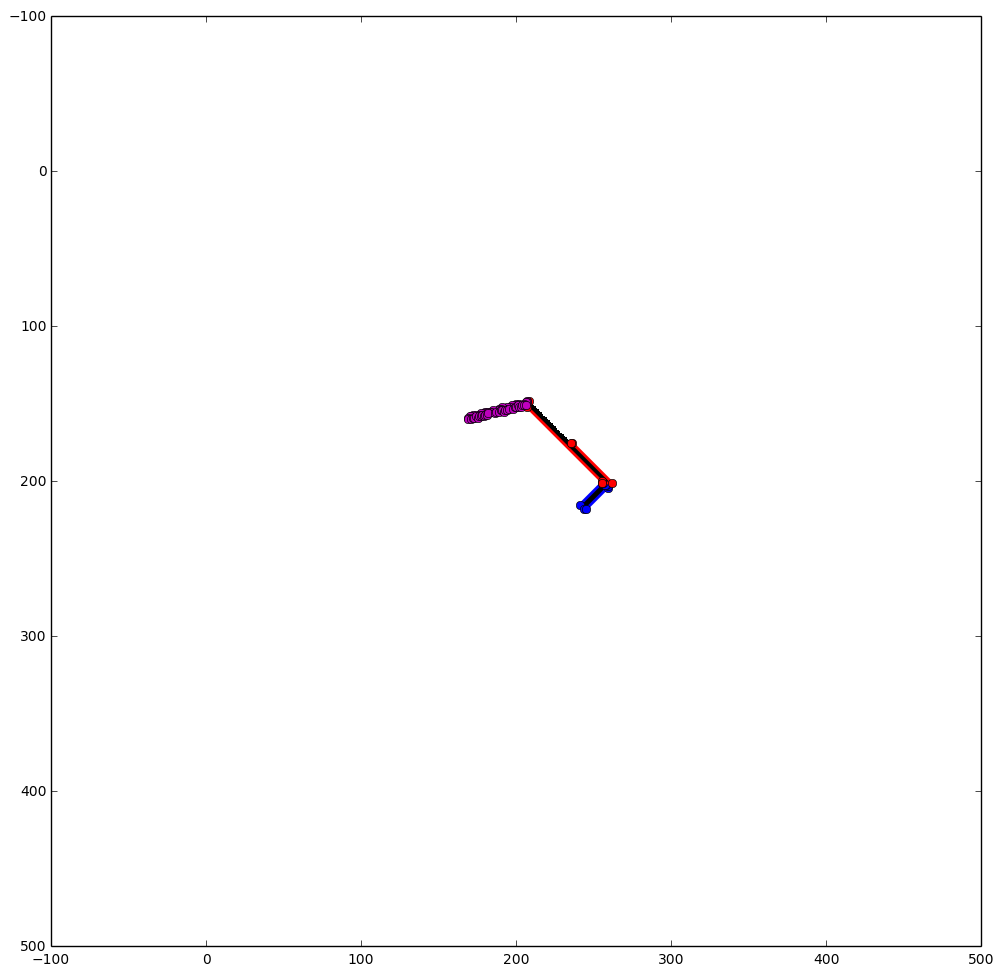

IndexError: index out of range

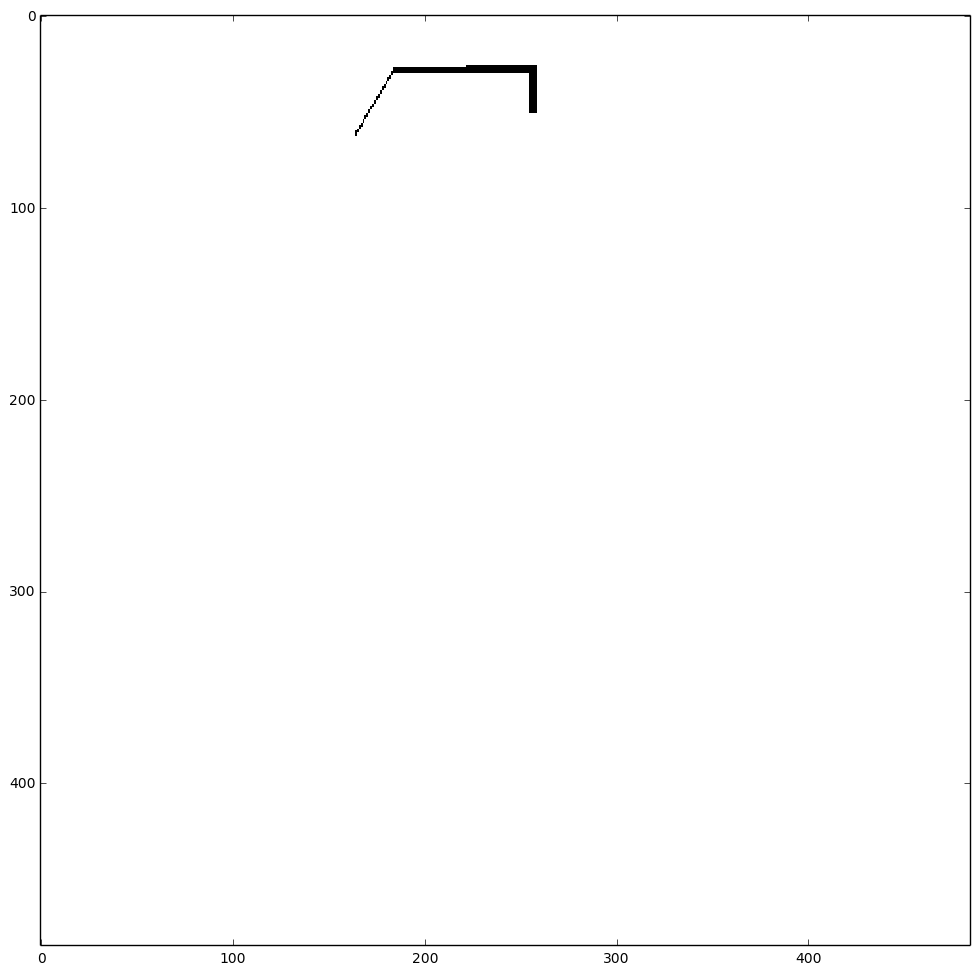

In [20]:
assman=dm.AssManager()
#New VertexCluster
vtx_data=dm.Data(2,0).as_vector()
dm
#Simply a list of VertexCluster (i.e. vertex-wise list of clusters)
print "There are ",vtx_data.size(),"vertex found in this event. Note that this is vertex-wise"
print

for vtx in vtx_data:
    for plane in xrange(3):
        fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
        shape_img = img_v[plane]
        shape_img=np.where(img_v[plane]>10.0,1.0,0.0).astype(np.uint8)
        plt.imshow(shape_img,cmap='Greys',interpolation='none')
        nz_pixels=np.where(shape_img>0.0)
        
        compound_data=dm.Data(3,plane+3)
        
        ass_t = np.array(assman.GetManyAss(vtx,par_data.ID()))
        if ass_t.size==0:continue
            
        par_data_v=compound_data.as_vector()
        for id_ in ass_t:
            track_cluster = par_data_v[id_]
            for atomic_id in xrange(track_cluster.size()):
                atomic = track_cluster[atomic_id]
                print atomic,atomic.size()
                ctor=np.array([[atomic[pid].x,atomic[pid].y] for pid in xrange(atomic.size())])
                plt.plot(ctor[:,0],ctor[:,1],'-o',lw=2)
                print "atomic dqdx size ",atomic
                dqdx_arr = np.array(atomic.dqdx())
                plt.plot(dqdx_arr)
        

        
        plt.show()
